In [3]:

import phd_ms
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [4]:

#Change this line to the directory where inputs are stored
IN_DIR = '/home/pbeamer/Documents/graphst/'

DATASET = 'V1_Human_Invasive_Ductal_Carcinoma_10xvisium_processed'
emb = 'X_gst'
INPUT_FILE= IN_DIR+DATASET+'_graphst'

#Set the scale parameters we want to use, and keys to save
RESOLUTIONS = [0.15,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
RES_KEYS = ['leiden_'+str(r) for r in RESOLUTIONS]
GROUND_TRUTH = None

In [5]:

#Run clusterings for each resolution and save
'''
Preprocess leiden clusterings for given dataset

Arguments: 
input_file: path to the input file
output_file: is the path where the output will be saved
embedding: anndata field of the embedding to use
resolutions: Resolution parameters
keys = Keys to save clusters in adata.obs
ground_truth: The ground truth field in adata.obs

Output: adata with clusters in adata.obs[keys[i]] for each resolution i
'''
phd_ms.tl.preprocess_leiden(INPUT_FILE,output_file=INPUT_FILE,emb='X_gst',resolution=RESOLUTIONS,res_keys=RES_KEYS,ground_truth=GROUND_TRUTH)

#read the adata file
adata = sc.read_h5ad(INPUT_FILE+'.h5ad')
adata.obsm['spatial'][:,1] = -adata.obsm['spatial'][:,1] #invert y axis for plotting

In [6]:
'''
Build cluster filtration

Arguments: 
input_file: path to the input file
output_file: is the path where the output will be saved
embedding: anndata field of the embedding to use
resolutions: Resolution parameters
keys = Keys to save clusters in adata.obs
ground_truth: The ground truth field in adata.obs

Output: adata with clusters in adata.obs[keys[i]] for each resolution i
'''
cluster_complex,clusterings= phd_ms.tl.cluster_filtration(adata,res_keys=RES_KEYS,index='jaccard',order=range(len(RES_KEYS)),)


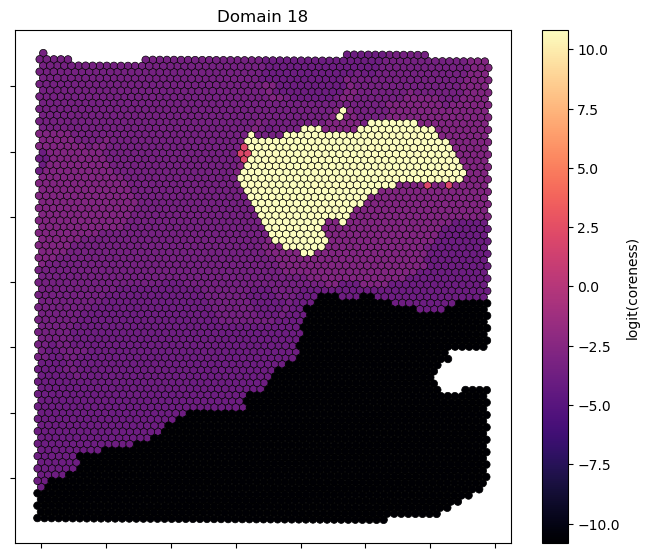

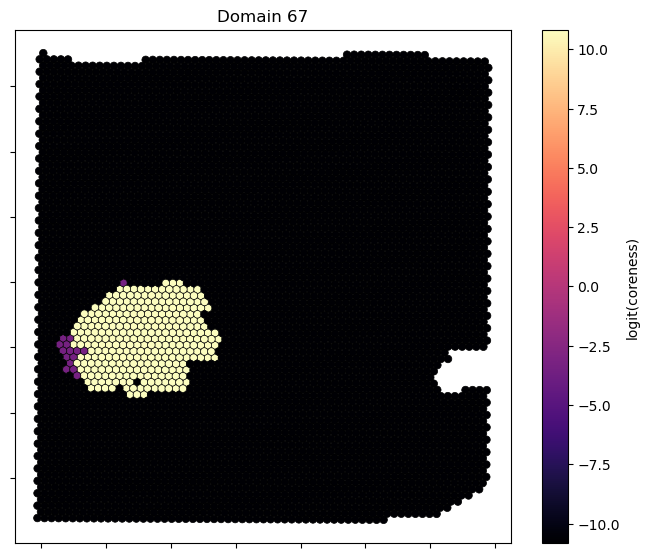

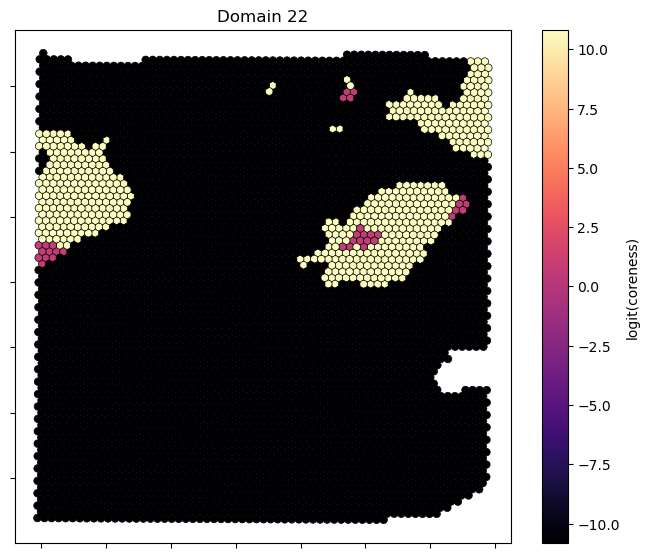

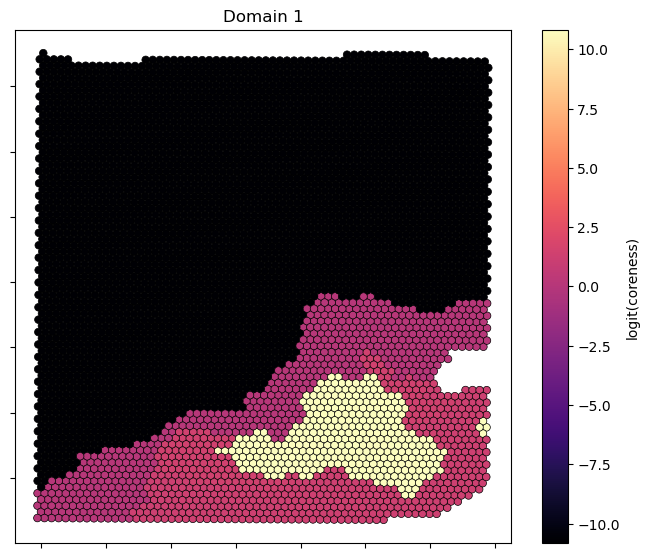

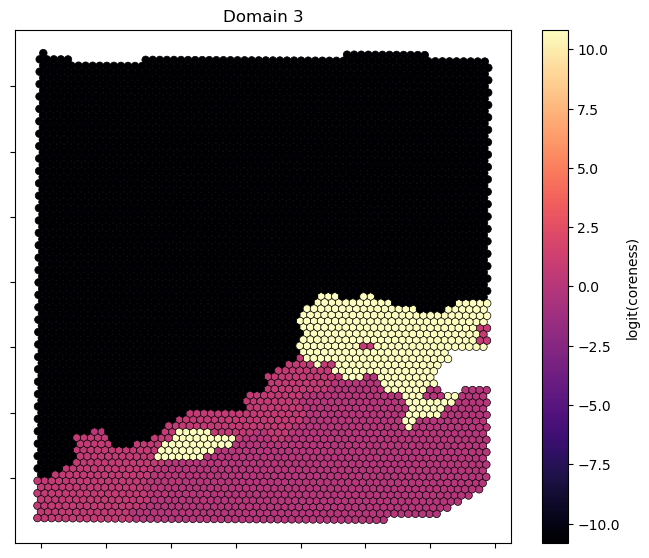

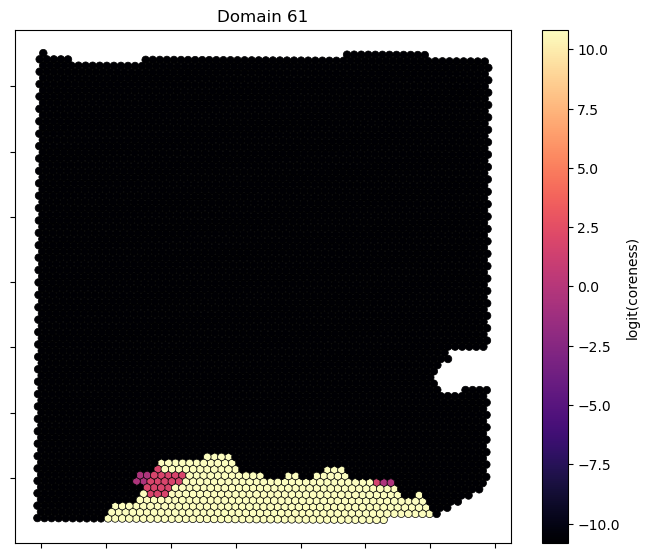

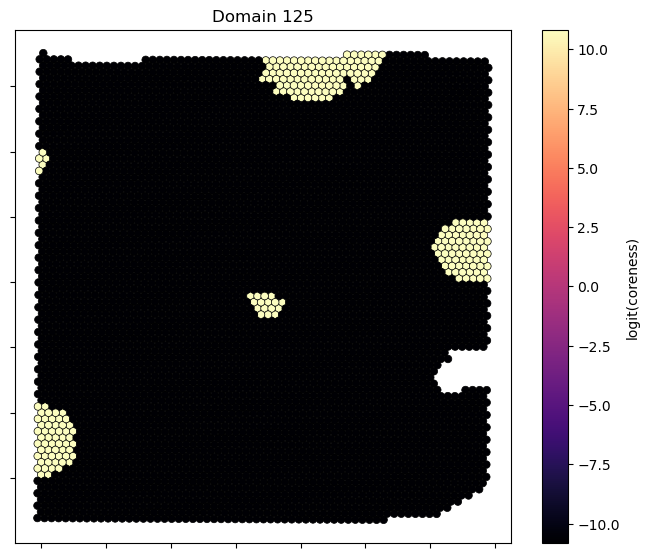

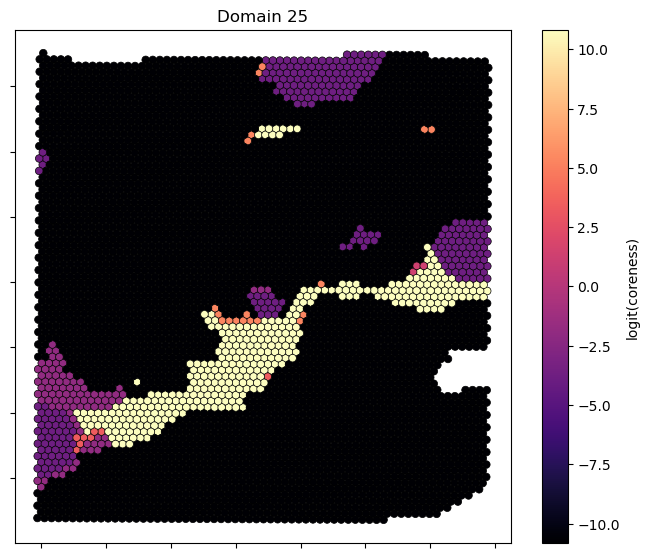

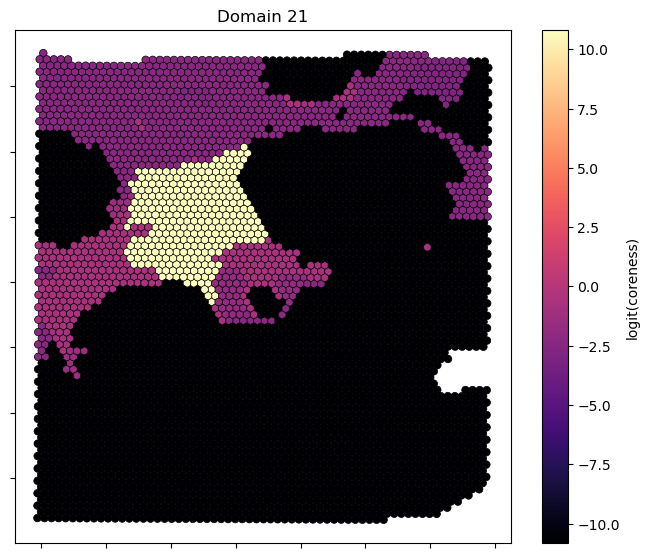

In [7]:

'''
Generate and map multiscale domains

Arguments:
spatial: spatial coordinates of points
cluster_complex: gudhi simplex tree of cluster filtration
clusterings: list of clusters at each resolution, containing cell indices
num_domains: number of multiscale domains to map, if 0 then all domains
filt: filter out persistent clusters with persistence less than this value
order: order of the output,'size' or default 'persistence'
redundant_filter: filter out domains which are to similar to previously examined domains, default is False
plots: 'on' to plot the domains

Output:
list of multiscale domains, consisting of coreness score for each point
'''

adata.obsm['multiscale']= phd_ms.tl.map_multiscale(adata.obsm['spatial'],cluster_complex,clusterings,num_domains=0,filt=0,order='size',redundant_filter=False,plots='off')
tumor_domains = [18,67,22,1,3,61,125,25,21]
for i in tumor_domains:
    phd_ms.tl.plot_multiscale(adata.obsm['multiscale'][:,i],adata.obsm['spatial'],title='Domain '+str(i))

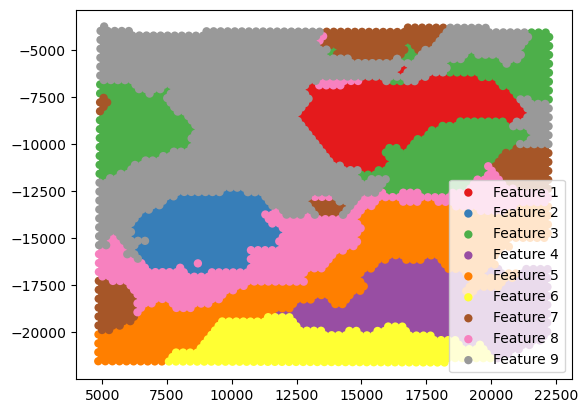

In [8]:
#Differential gene expression analysis
import pandas as pd

#List of highly expresssed genes in ductal BRCA from OncoDB
brca_express =pd.read_csv(IN_DIR+'expression_diff_BRCA.txt', sep="\t", header=0)

    
#plot the diff expressed genes
adata.obs['tumor_cat'] = phd_ms.tl.construct_clustering(adata,tumor_domains)



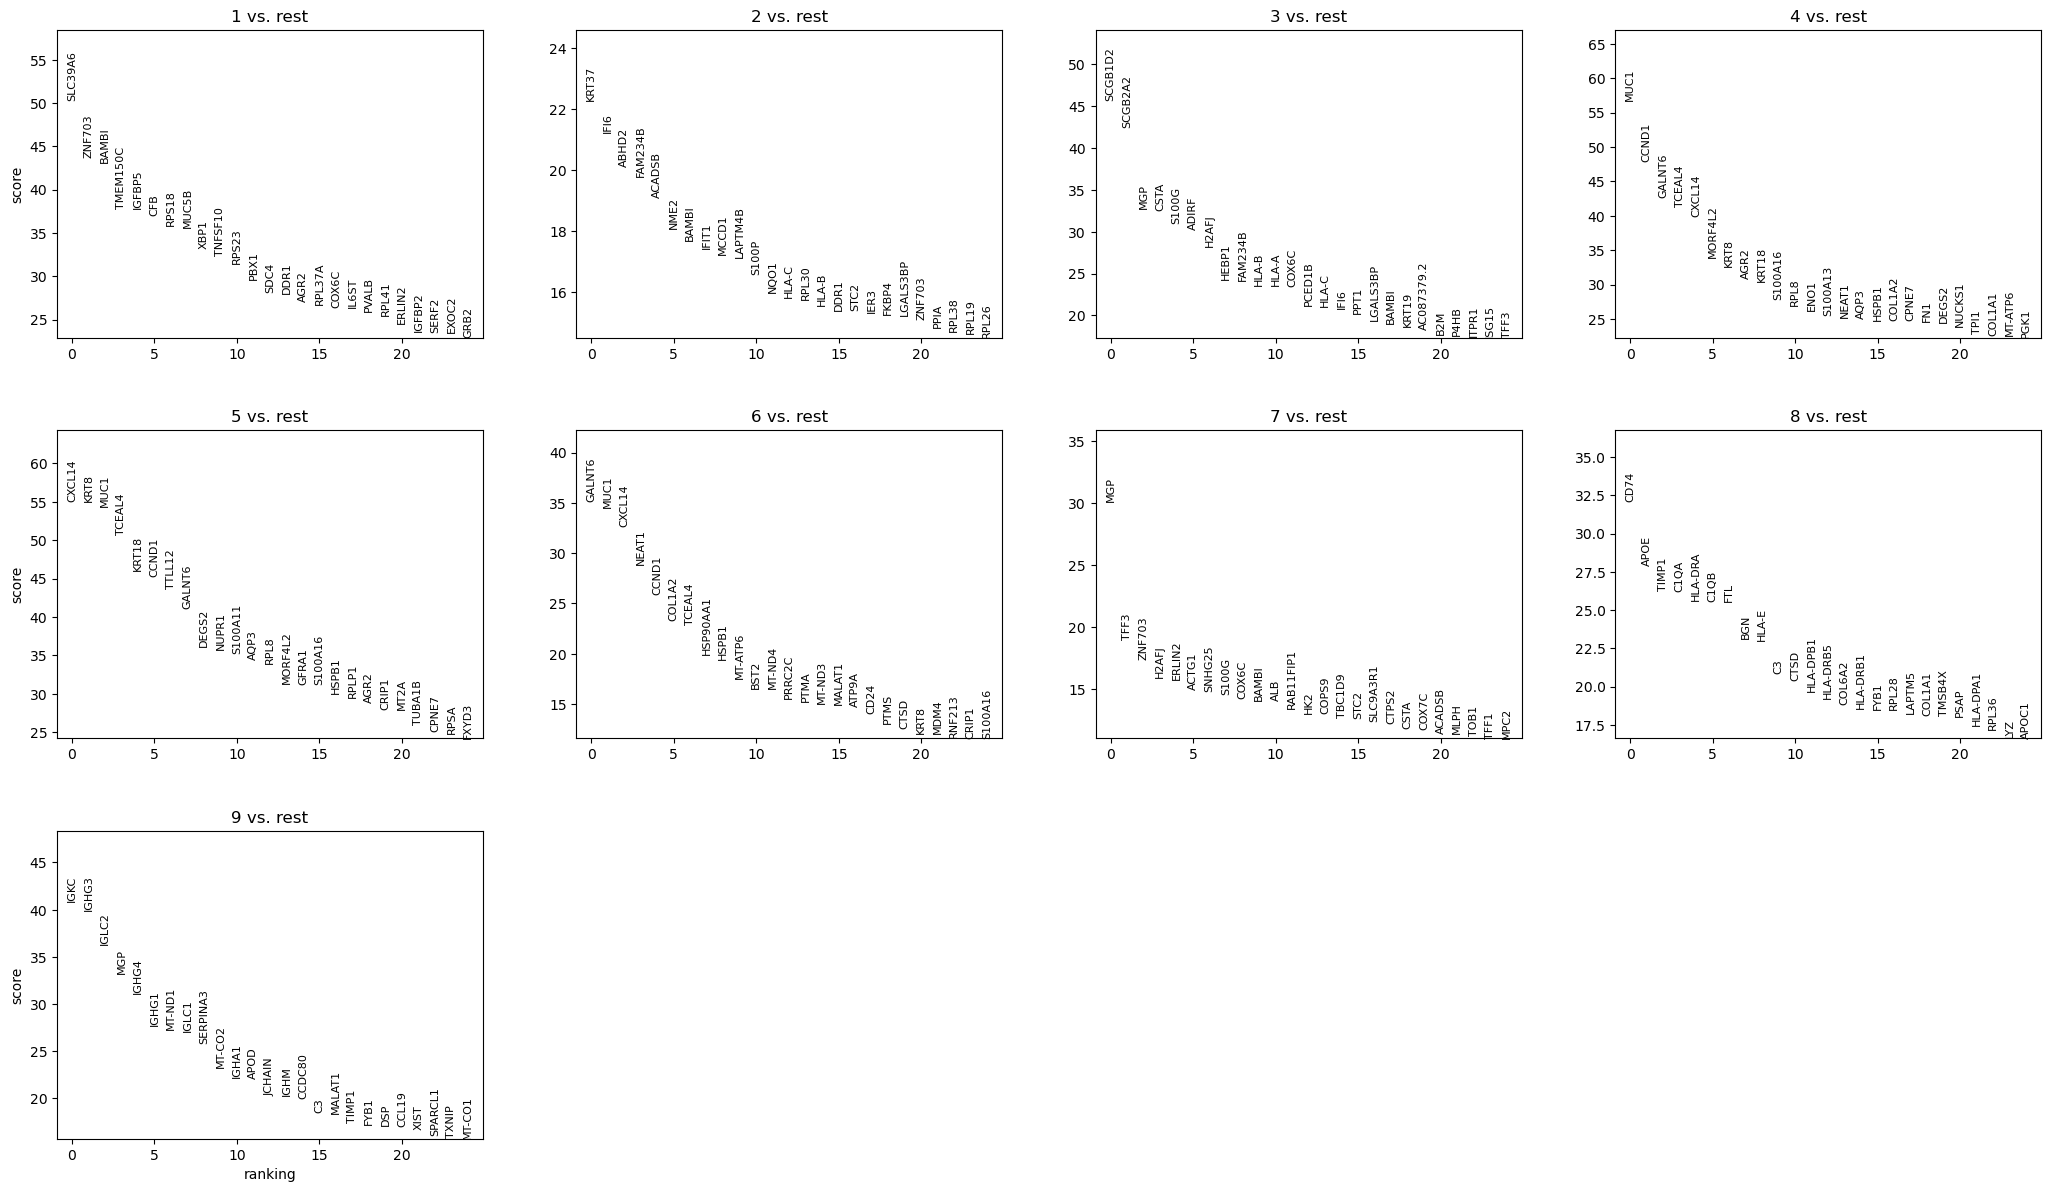

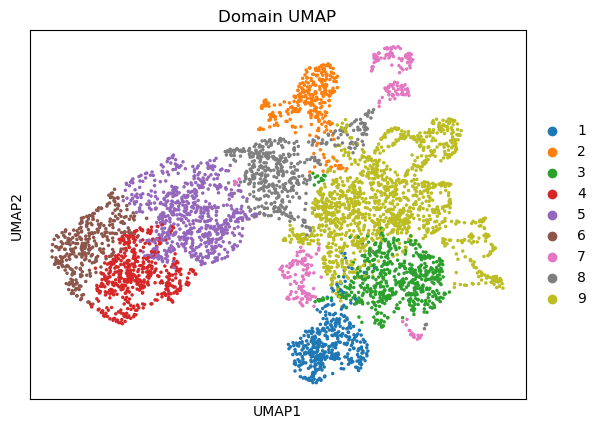

Highly expressed genes in category: 1
SLC39A6
BAMBI
TMEM150C
MUC5B
TNFSF10
PVALB
EXOC2
GRB2
ELP2
COLEC12
AC010998.3
AGR3
POTEC
LINC00645
REPS2
LINC02224
SOCS2
AFP
ST8SIA6-AS1
FSIP1
CLSTN2
FGFR4
CARTPT
RBM20
PDE8B
ARHGAP32
CACNA1H
CKB
AC037198.2
MRPS30-DT
AP005121.1
PTPRN2
KCNE4
VSTM2A
CAMK2B
SYT13
CHST1
SOCS2-AS1
ARHGAP40
NXPH1
FAIM2
STS
LINGO1
SCD5
CA2
AL357054.4
AC048352.1
NELL2
PLEKHD1
SALL2
HUS1B
DNAL4
EAF2
TRPA1
IGDCC3
CA14
SLC4A10
CLUL1
PNCK
CDSN
KIAA2012-AS1
SNAP25
FP475955.3
SCUBE3
HOXC10
FCRLB
SLC27A2
TMPRSS6
ERRFI1
LARGE2
AL357054.3
PLPPR3
C2orf50
OLFM1
CST9
ZNF442
AL022341.2
KCNF1
AL590666.4
AC133644.2
RHBG
TPSG1
CTNND2
C1orf115
ZDHHC11
LIN28A
CLCNKB
CYP2A6
C1orf226
NHLRC4
HOXC-AS3
PTPRT
SLC6A4
SEZ6L
ST6GALNAC5
CAPN13
AL390294.1
NR6A1
FCGR3B
AC132872.2
ELF5
SPTY2D1OS
RASSF6
TBR1
PRTFDC1
FOXI1
ZNF790-AS1
RASSF10
HULC
EXOC3L4
LRRC10B
AC005808.1
AC006449.2
UNC5CL
114
Highly expressed genes in category: 2
KRT37
ACADSB
MCCD1
LAPTM4B
SERPINA5
MBOAT1
SPTSSB
RP1
IGFBP3
SIAH2
STMND1


In [9]:
#Differential gene expression analysis

sc.tl.rank_genes_groups(adata, 'tumor_cat', method='t-test', key_added = "t-test",use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")
plt.show()

sc.pl.umap(adata, color='tumor_cat',title='Domain UMAP')
plt.show()


for cat in adata.obs['tumor_cat'].cat.categories.tolist():
    print('Highly expressed genes in category:', str(cat))
    sig = sc.get.rank_genes_groups_df(adata,group=str(cat),key='t-test')
    genes =[]
    for index,row in sig.iterrows():
        if row['logfoldchanges'] > 1.5 and row['pvals_adj'] < 0.001:
            genes.append(row['names'])
            print(row['names'])
    print(len(genes))

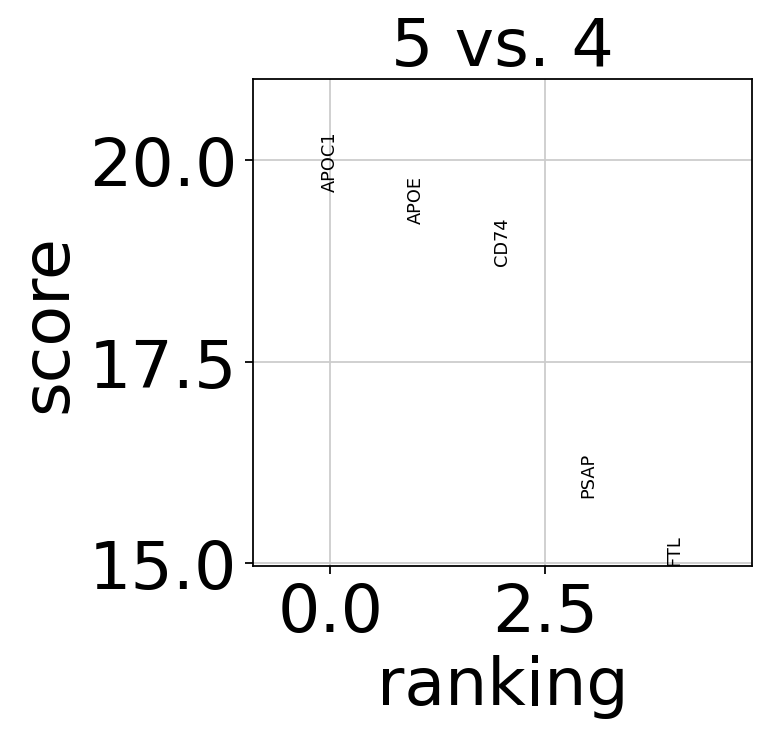

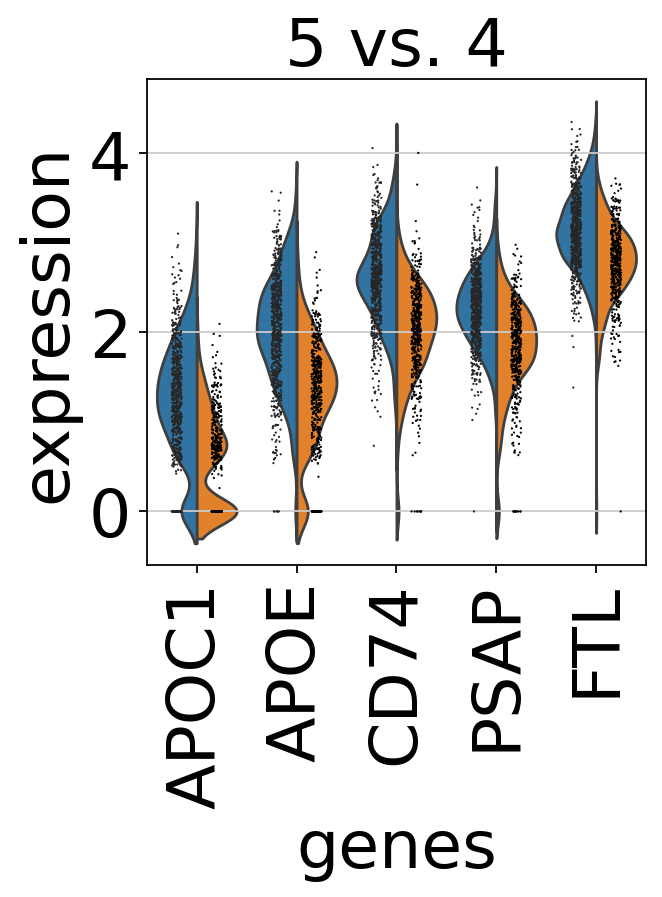

Overexpressed oncogenes in domain 5:
APOC1
MMP1
SDS
APLNR
P2RY6
MMP3
SELL
Total:7


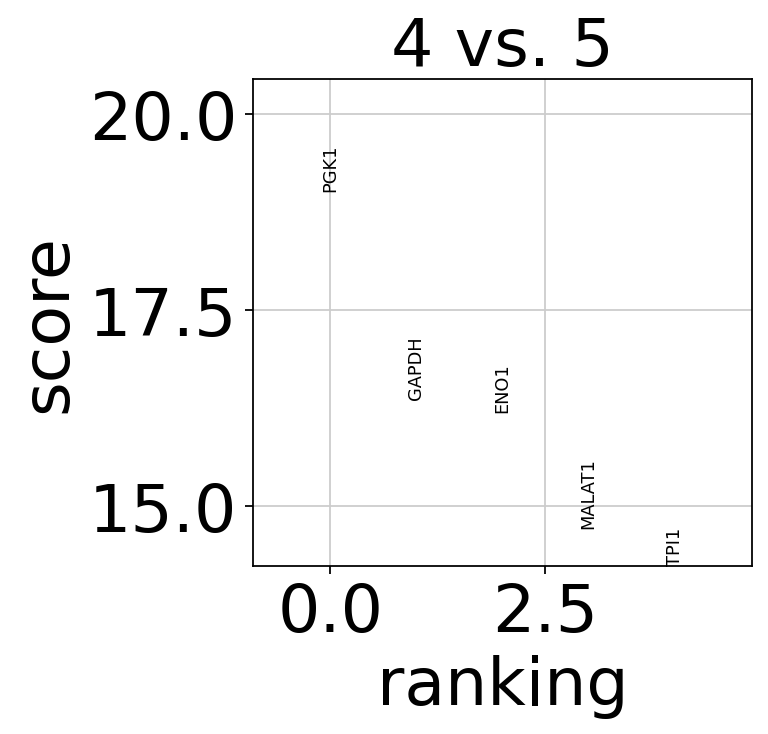

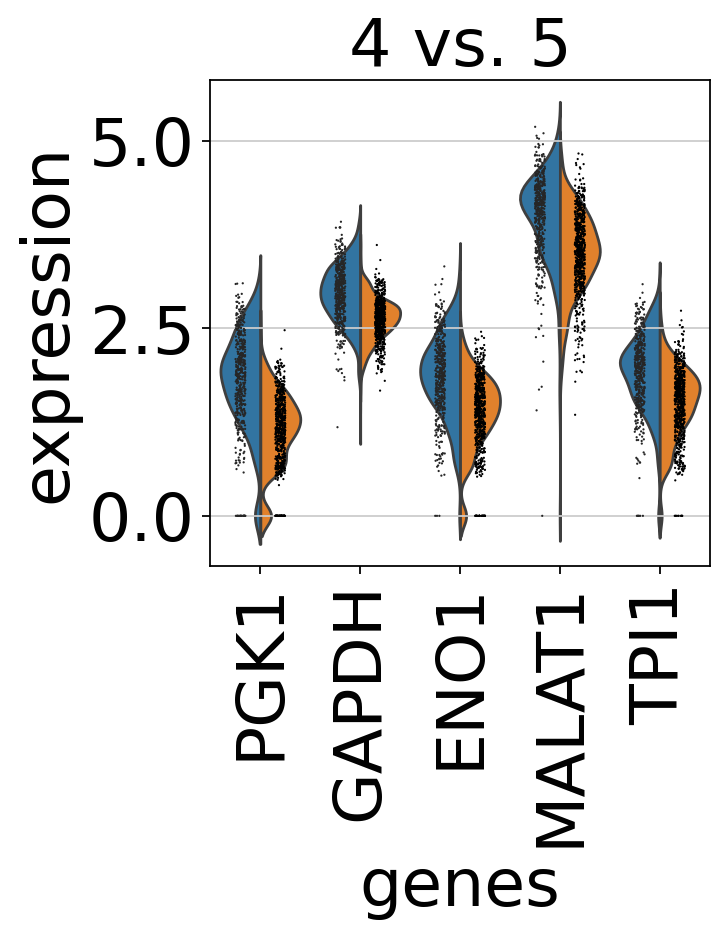

Overexpressed oncogenes in domain 4:
MIR210HG
EGLN3
ANGPTL4
Total:3


In [12]:

#Run differential gene expression between domains 4 and 5

compare = ['4','5']
sc.set_figure_params(scanpy=True, fontsize=30)
sc.tl.rank_genes_groups(adata, 'tumor_cat', groups=[compare[1]], reference=compare[0],method='t-test',use_raw=False,key_added='compare1')
sc.pl.rank_genes_groups(adata, groups=[compare[1]], n_genes=5,key='compare1')
ax=sc.pl.rank_genes_groups_violin(adata,groups=compare[1],n_genes=5,save=False,key='compare1')
    
        
sig = sc.get.rank_genes_groups_df(adata,group=compare[1],key='compare1')
genes =[]
print('Overexpressed oncogenes in domain 5:')
for index,row in sig.iterrows():
    if row['logfoldchanges'] > 1.5 and row['pvals_adj'] < 0.001:
        if row['names'] in list(brca_express['Gene']):
            genes.append(row['names'])
            print(row['names'])
print('Total:'+str(len(genes)))
    
sc.tl.rank_genes_groups(adata, 'tumor_cat', groups=[compare[0]], reference=compare[1],method='t-test',use_raw=False,key_added='compare2')
sc.pl.rank_genes_groups(adata, groups=[compare[0]], n_genes=5,key='compare2')
sc.pl.rank_genes_groups_violin(adata,groups=compare[0],n_genes=5,save=False,key='compare2')
    
print('Overexpressed oncogenes in domain 4:')
sig = sc.get.rank_genes_groups_df(adata,group=compare[0],key='compare2')
genes =[]
for index,row in sig.iterrows():
    if row['logfoldchanges'] > 1.5 and row['pvals_adj'] < 0.001:
        if row['names'] in list(brca_express['Gene']):
            genes.append(row['names'])
            print(row['names'])
print('Total:'+str(len(genes)))

#print(len(adata.obs['tumor_cat'].cat.categories.tolist()))
